## Challenge 2: Summarizing Topics with Natural Language Processing

### Import Libraries

In [26]:
import os
import re
import pandas as pd

# pyLDAvis
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

# Gensim
import gensim, spacy
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

# WordCloud
from wordcloud import WordCloud, STOPWORDS

# NLTK Stop Words
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Matplotlib
import matplotlib.pyplot as plt
import warnings

# Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

### Loading Data

In [27]:
# Putting all articles into a list
files = [os.path.join('challenge2-articles', file_name) for file_name in os.listdir('challenge2-articles')]

In [28]:
# Read all articles into a dataframe
articles = pd.DataFrame()
for f in files:
    curr_file = open(f, mode = 'r', encoding = 'utf-8').read()
    articles = pd.concat([articles, pd.DataFrame([[curr_file]])])
articles = articles.reset_index(drop = True)
articles.rename(columns = {0: 'Text'}, inplace = True)

articles.head()

,Text
0,The extensive drain on the body will eventual...
1,The contributions they have made have been in...
2,\n\nThe Eterna Diamonds are considered one of ...
3,. The cure for Pires is the “La La Eterna
4,"\n\nDespite its toxicity, the incense is still..."


### **Approach 1: Word Cloud**

#### I. Preprocessing Text

In [29]:
def sentences_to_words(sentences):
    for s in sentences:
        s = re.sub(r'\s+', ' ', s) # Remove newline characters
        s = re.sub(r"\'", "", s) # Remove single quotes
        s = gensim.utils.simple_preprocess(str(s), deacc = True)
        yield(s)

def process_words(words, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    # Initializing bigram and trigram models 
    bigram = gensim.models.Phrases(words, min_count=5, threshold=10) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[words], threshold=10)  
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    words = [[word for word in simple_preprocess(str(w)) if word not in stop_words] for w in words]
    words = [bigram_mod[word] for word in words]
    words = [trigram_mod[bigram_mod[word]] for word in words]
    
    output = []
    nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])
    for word in words:
        doc = nlp(" ".join(word))
        output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    
    # Removing stopwords
    output = [[word for word in simple_preprocess(str(w)) if word not in stop_words] for w in output]
    return output
    

In [30]:
warnings.filterwarnings("ignore")
# Break sentences in dataframe into words
analysis_words = list(sentences_to_words(articles['Text'].values))

# Process words, form bigrams, trigrams, lemmatization
processed_words = process_words(analysis_words)

#### II. Making Word Cloud

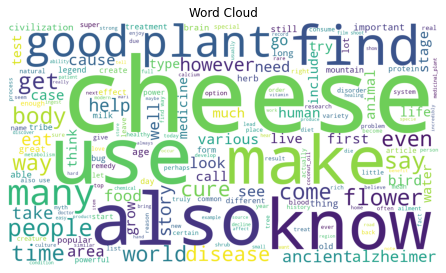

In [31]:
# Setting up wordcloud
wordcloud_words = [y for x in processed_words for y in x]
describe_text = pd.Series(wordcloud_words)
wordcloud = WordCloud(width = 1280, height = 720, stopwords = stop_words, background_color = 'white').generate(' '.join(describe_text))

# Displaying plot
warnings.filterwarnings("ignore")
plt.imshow(wordcloud)
plt.title('Word Cloud')
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()


### **Approach 2: Scikit-learn and Latent Dirichlet Allocation**

Inspired by: https://nbviewer.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb#topic=0&lambda=1&term=

#### I. Converting to Document-Term Matrix

In [32]:
%%capture
# Using TfidfVectorizer to fit prediction algorithm using words
tfidf_vectorizer = TfidfVectorizer(strip_accents = 'unicode', stop_words = 'english', lowercase = True,
    token_pattern = r'\b[a-zA-Z]{3,}\b', max_df = 0.5, min_df = 10)
    
dtm_tfidf = tfidf_vectorizer.fit_transform(articles['Text'].values)

#### II. Fitting Latent Dirichlet Allocation (LDA) Models

In [33]:
%%capture
lda_tfidf = LatentDirichletAllocation(n_components = 20)
lda_tfidf.fit(dtm_tfidf)

#### III. Visualizing with pyLDAvis

In [34]:
warnings.filterwarnings("ignore")
pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tfidf_vectorizer, mds = 'mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16    -0.056238  0.082143       1        1  37.975437
8      0.139289 -0.325805       2        1   8.351007
10     0.177027  0.254276       3        1   8.209419
9     -0.242163 -0.252592       4        1   5.377088
19    -0.195894  0.203969       5        1   4.328325
13    -0.080829  0.199126       6        1   3.344413
3      0.192959  0.015356       7        1   3.131756
18    -0.220528  0.073941       8        1   3.030104
12     0.097247  0.162016       9        1   3.005615
5      0.208744 -0.044009      10        1   2.991078
11    -0.125913 -0.121373      11        1   2.872851
7      0.003951 -0.129308      12        1   2.304101
4     -0.138084 -0.036448      13        1   2.178672
17     0.078610 -0.041843      14        1   2.126441
2      0.126925 -0.122022      15        1   2.090911
15     0.012119  0.076432      16        1   1.957366
14     0.085597  0.017583      17        1   1.895357
0     -0.012700 -0.012381      18        1   1.791036
6     -0.058448 -0.018147      19        1   1.567405
1      0.008329  0.019087      20        1   1.471619, topic_info=        Term       Freq      Total Category  logprob  loglift
19    cheese  14.000000  14.000000  Default  30.0000  30.0000
52      like   5.000000   5.000000  Default  29.0000  29.0000
66  mountain   3.000000   3.000000  Default  28.0000  28.0000
12       bug   4.000000   4.000000  Default  27.0000  27.0000
78     plant   5.000000   5.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
46   include   0.041587   2.328651  Topic20  -4.8943   0.1936
58   looking   0.041587   4.629991  Topic20  -4.8943  -0.4937
66  mountain   0.041587   3.985415  Topic20  -4.8943  -0.3438
19    cheese   0.041587  14.402904  Topic20  -4.8943  -1.6286
40   healing   0.041587   2.667507  Topic20  -4.8943   0.0577

[948 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.707502      able
0         9  0.353751      able
1         1  0.408840  actually
1        13  0.408840  actually
2         3  0.499255  ailments
...     ...       ...       ...
112      16  0.179428       way
113       1  0.596437     world
113      10  0.198812     world
114       1  0.354563     years
114      12  0.354563     years

[181 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 9, 11, 10, 20, 14, 4, 19, 13, 6, 12, 8, 5, 18, 3, 16, 15, 1, 7, 2])